# Recommender Systems

When you visit sites like Netflix and Amazon, they usually suggest shows or products that they think you will be interested in.  This is big business:  if a company suggests products that are useful to you, you will probably buy more or spend more time on their site, which makes them happy.  In fact, Netflix recently offered a $1 million prize for an algorithm that would improve the accuracy of their recommendations by 10 percent.  This proved to be exceptionally difficult, and none of the hundreds of teams that attempted could do it.

Here, we'll learn how singular value decompositions have been applied to this problem using the data set that we created with our survey.  We presented students with a number of television shows and asked them to rate the ones they are familiar with.  The goal is to predict which of the shows they left unrated that they will like.  

To get started, evaluate the next cell, which loads a bunch of stuff.

In [1]:
import csv
import numpy as np

def load_ratings():
    reader = csv.reader(open('student-ratings.csv'))
    rows = [row[1:] for row in reader]
    titles = rows.pop(0)
    titles = [title[14:-1] for title in titles]
    values = {'1':1, '2':2, '3':3, '4':4, '5':5, 'N': 0}
    entries = []
    for row in rows:
        entries.append(map(int, [0 if len(e) == 0 else values[e[0]] for e in row]))
    A = matrix(RDF, entries)
    return A, titles

def display_row(A, k):
    return display_matrix(A.matrix_from_rows([k]))

def square(ll, dims, fillcolor, strokecolor):
    x, y = ll
    w, h = dims
    points = [ll, [x+w,y], [x+w, y+h], [x, y+h]]
    return polygon(points, rgbcolor=fillcolor, axes=False) + polygon(points,rgbcolor=strokecolor, fill=False,axes=False)

def display_matrix(A):
    A = copy(A)
    max = np.max(np.abs(A))
    A = A/max
    squares=[]
    y = A.nrows()-1
    for i, row in enumerate(A.rows()):
        x = 0
        for c in row:
            fillcolor = [c]*3
            if c < 0: fillcolor=[-c,0,0]
            if c == 0: fillcolor = [0,0,0]
            if c > 0:  fillcolor = [0.5, 0.5+0.5*c, 0.5]
            strokecolor = [1 - f for f in fillcolor]           
            squares.append(square([x,y], [1,1], fillcolor, strokecolor))
            x += 1
        y -= 1
    return sum(squares)

def plotSV(A):
    return list_plot(A.singular_values(), size=20)

def approximation(A, k):
    U, Sigma, V = A.SVD()
    m = A.nrows()
    n = A.ncols()
    S = matrix(RDF, m, n, [0] * (m*n))
    k = np.min([k,m,n])
    for i in range(k):
        S[i,i] = Sigma[i,i]
    return U*S*V.T

def find_rated_entries(A):
    ratings = []
    for row in A.rows():
        ratings.append([i for i, e in enumerate(row) if e > 0])
    return ratings

def mean_ratings(A):
    means=[]
    for col in A.columns():
        col = np.array(col)
        means.append(sum(col)/np.count_nonzero(col))
    return means

def replace_missing_values(A):
    cols = []
    for col in A.columns():
        col = np.array(col)
        mean = sum(col)/np.count_nonzero(col)
        col[col==0] = mean
        cols.append(vector(col))
    return matrix(cols).T

def subtract_user_means(A):
    global user_means
    user_means = []
    rows = []
    for row in A.rows():
        row = np.array(row)
        mean = sum(row)/np.count_nonzero(row)
        user_means.append(mean)
        rows.append(vector(row - mean))
    return matrix(rows)

def add_user_means(A):
    means = matrix([[mean] * A.ncols() for mean in user_means])
    return A + means

def find_top_ratings(A, user):
    row = A[user]
    ratings = sorted(zip(range(len(row)), row), key=lambda x: -x[1])
    return [r[0] for r in ratings]

def display_top_ratings(user):
    rated_entries = find_rated_entries(R)
    rated = rated_entries[user]
    ratings = [[i, R[user][i]] for i in rated]
    sorted_ratings = sorted(ratings, key=lambda x: -x[1])
    recs = [[titles[r[0]], R[user,r[0]]] for r in sorted_ratings]
    return recs[ : min(7, len(recs))]

def display_top_recommendations(A, user):
    rated_entries = find_rated_entries(R)
    rated = set(rated_entries[user])
    recs = find_top_ratings(A, user)
    recs = [[titles[i], n(A[user,i], digits=2)] for i in recs if i not in rated]
    return recs[ : min(7, len(recs))]

def remove_user_rating(user, title):
    try:
        index = titles.index(title)
    except:
        print('Unknown title')
        return
    Rc = copy(R)
    Rc[user,index] = 0
    A = replace_missing_values(Rc)
    A = subtract_user_means(A)
    U, Sigma, V = A.SVD()
    S = matrix(RDF, Sigma.nrows(), Sigma.ncols(), [0] * (Sigma.nrows() * Sigma.ncols()))
    for i in range(10):
        S[i,i] = Sigma[i,i]
    Ak = U*S*V.T
    Ak = add_user_means(Ak)
    rated_entries = find_rated_entries(Rc)
    rated = set(rated_entries[user])
    recs = find_top_ratings(Ak, user)
    recs = [[titles[i], n(Ak[user,i], digits=2)] for i in recs if i not in rated]
    return recs[ : min(7, len(recs))]

When we evaluate the next cell, we will load the student ratings into a matrix, which we call `R` (for "ratings!").  *Don't use R to label anything else in this notebook.*  We also load a list of `titles` that we will use to refer to shows later on.  Each row of the matrix corresponds to a student, and each column corresponds to a show.  If a students has not rated the show, the corresponding entry is zero;  otherwise, their rating is loaded into the matrix.  

In [2]:
R, titles = load_ratings()

To get a sense of what this matrix is like, we can display it using colors using the cell below.  Black represents 0, which means that no rating was given.  Dark green means a low rating and bright green means a high rating.

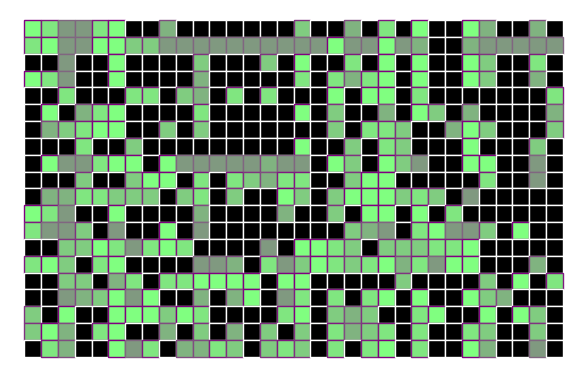

In [3]:
display_matrix(R.matrix_from_rows(range(20)))

Before we get started, let's look at which shows are most popular.  For each show, let's find the average rating given to it and display the ratings in decreasing order

In [4]:
means = zip(range(R.ncols()),  mean_ratings(R))
sorted_means = sorted(means, key=lambda x: -x[1])
popular = [titles[mean[0]] for mean in sorted_means]
popular

['Coco',
 'Stranger Things',
 'The Office',
 'Breaking Bad',
 'Incredibles 2',
 'Guardians of the Galaxy',
 'Better Call Saul',
 'Parks and Recreation',
 'You',
 'Black Mirror',
 'Arrested Development',
 'New Girl',
 'Riverdale',
 'The Haunting of Hill House',
 'Criminal Minds',
 'The Good Place',
 'That 70s Show',
 'The Great British Baking Show',
 'Sherlock',
 'Gilmore Girls',
 "Grey's Anatomy",
 'NCIS',
 'The Vampire Diaries',
 'Friends',
 'Bird Box',
 'Cars 3',
 'Despicable Me 3',
 'Orange is the New Black',
 'Glee',
 'Tidying Up',
 'The Big Bang Theory',
 'The Walking Dead']

Let's get to work constructing a recommendation system.  We have our matrix `R`, but there are lots of missing entries due to the fact that students did not rate every show.  Our first task is to fill in those missing values.  Our strategy will be to replace all the unrated entries by the average rating for that particular show.  In essence, we are assuming that every student would rate the show with the average rating.  This is probably not right so we introducing some "noise" that we will later remove with the SVD.

In [5]:
A = replace_missing_values(R)

A second issue is students have different standards.  Some students are kind of lenient and so give everything a '4' or '5'.  Others are tougher critics and use '1' and '2' pretty frequently.  Left uncorrected, the lenient critic could inflate the ratings of some shows and the tougher critic could suppress some ratings.  We will therefore look at every user and subtract their average rating as a way to neutralize this effect.

In [6]:
A = subtract_user_means(A)

Plot the singular values of `A` below using the `plotSV(A)` command.

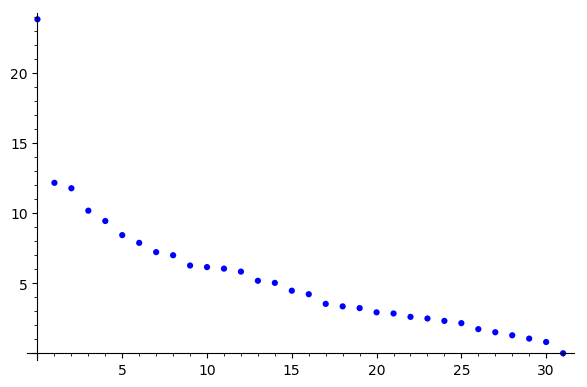

In [7]:
plotSV(A)

Let's think about what we've done in terms of signal and noise.  The ratings that we began with form the signal, but we had to fill out the matrix to get to the point where we can apply an SVD.  The additional entries in the matrix reflect the original ratings somewhat, since they are based on averages, but they are somewhat crude approximations.  We can think of this as noise.  We can separate the signal and noise by using the SVD to form a low rank approximation of $A$. Using the cell below, construct $A_k$, a rank $k$ approximation to $A$.  Using the plot of the singular values of $A$ above, what seems like a reasonable choice for $k$? 

In [8]:
k=3        # insert your value of k below
Ak = approximation(A, k)

Now we will add each user's means back in so we can interpret the values of $A_k$.

In [9]:
Ak = add_user_means(Ak)

We are now ready to make some recommendations.  Our matrix $A_k$ should approximate the ratings that every student would give to every show.  We can make recommendations for a particular user by running through the row of the matrix corresponding to that user and picking out the shows with the highest ratings that were not made by the student themself.

Evaluating the cell below will show you how many shows each of the students rated.  For instance, student `0` rated 14 shows.  

In [10]:
counts = [[i, len(ratings)] for i, ratings in enumerate(find_rated_entries(R))]
matrix(counts).T

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[14 30 11 14 12 12 15  8 23 15 20 11 16 19 22 16 18 18 18 19 19 21 18 21 17 23 19  8 23 10 22 19 25 17 13 13 17 17 21 22 21 24]

Now we're ready to look at our recommendations.  Notice that student `7` only rated 8 shows so they may appreciate seeing our recommendations.  First, use the command `display_top_rankings(n)` to see the top 7 seven shows rated by student `n`.

In [11]:
display_top_ratings(7)

[['Guardians of the Galaxy', 5.0],
 ['Stranger Things', 5.0],
 ['Bird Box', 4.0],
 ['The Office', 4.0],
 ['Cars 3', 3.0],
 ['NCIS', 3.0],
 ['Orange is the New Black', 3.0]]

We can now see the recommendations for student `n` using `display_top_recommendations(Ak, n)`.  How do these recommendations look?

In [12]:
display_top_recommendations(Ak, 7)

[['Coco', 4.3],
 ['Parks and Recreation', 4.2],
 ['Breaking Bad', 4.1],
 ['You', 4.1],
 ['Arrested Development', 4.0],
 ['Incredibles 2', 4.0],
 ['New Girl', 4.0]]

You can now look at the ratings and recommendations for other students.  You might also see what happens when you change the rank of the approximation to another value of $k$.

Here's a way to test how good our recommendations are.  Let's look at the ratings for user `20`.

In [13]:
display_top_ratings(20)

[['Better Call Saul', 5.0],
 ['The Big Bang Theory', 5.0],
 ['Black Mirror', 5.0],
 ['Breaking Bad', 5.0],
 ['Guardians of the Galaxy', 5.0],
 ['New Girl', 5.0],
 ['The Office', 5.0]]

We can try to validate our recommendations by removing one of the titles rated highly by user `20` and see if that title will be recommended.  For instance, user `20` rated Breaking Bad highly.  We will remove that rating, repeat the calculations, and see if Breaking Bad is recommended to user `20`.  The command `remove_user_rating(user, title)` will do that.

In [14]:
remove_user_rating(20, 'Breaking Bad')

[['Breaking Bad', 4.6],
 ['Incredibles 2', 4.5],
 ['Coco', 4.2],
 ['The Great British Baking Show', 4.1],
 ['You', 3.7],
 ['Riverdale', 3.6],
 ['Cars 3', 3.4]]

Try this out with other titles and other users.  What do you find?  How well does the recommendation system work?  Are there certain titles that work better than others?  Why do you think that is?

In [15]:
def subtract_user_means(A):
    global user_means
    user_means = []
    rows = []
    for row in A.rows():
        row = np.array(row)
        mean = sum(row)/np.count_nonzero(row)
        user_means.append(mean)
        rows.append(vector(row - mean))
    return matrix(rows)
A=matrix(RDF,[1,3,3,2,2, 2,4,2,2,4, 1,3,2.5,5,1,4,3,2,3,3,2,1,2,3,2,1])
A

[1.0 3.0 3.0 2.0 2.0 2.0 4.0 2.0 2.0 4.0 1.0 3.0 2.5 5.0 1.0 4.0 3.0 2.0 3.0 3.0 2.0 1.0 2.0 3.0 2.0 1.0]

In [16]:
A.rank()

1

In [17]:
Adm=subtract_user_means(A)
Adm

[-1.4423076923076925  0.5576923076923075  0.5576923076923075 -0.4423076923076925 -0.4423076923076925 -0.4423076923076925  1.5576923076923075 -0.4423076923076925 -0.4423076923076925  1.5576923076923075 -1.4423076923076925  0.5576923076923075 0.05769230769230749  2.5576923076923075 -1.4423076923076925  1.5576923076923075  0.5576923076923075 -0.4423076923076925  0.5576923076923075  0.5576923076923075 -0.4423076923076925 -1.4423076923076925 -0.4423076923076925  0.5576923076923075 -0.4423076923076925 -1.4423076923076925]

In [18]:
def pretty(Q):
    print Q.str(rep_mapping=lambda x: 
    str(x.n(digits=3)))
def pretty_real(Q):
    M=matrix(np.matrix.round(np.array(Q).real,3))
    return M

In [19]:
pretty(Adm)

[ -1.44  0.558  0.558 -0.442 -0.442 -0.442   1.56 -0.442 -0.442   1.56  -1.44  0.558 0.0577   2.56  -1.44   1.56  0.558 -0.442  0.558  0.558 -0.442  -1.44 -0.442  0.558 -0.442  -1.44]


In [20]:
Adm.rank()

1

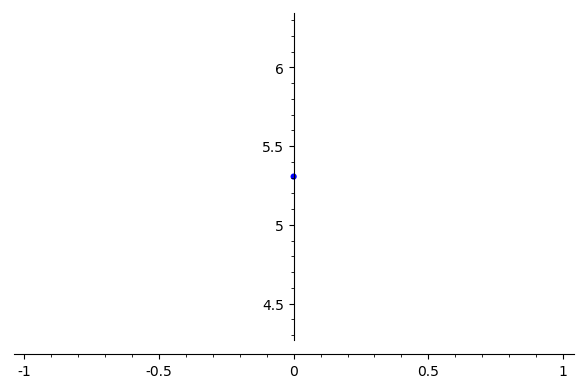

In [21]:
plotSV(Adm)

In [22]:
Adm_approx=approximation(Adm, 1)
Adm_approx

[  -1.442307692307693   0.5576923076923076   0.5576923076923076 -0.44230769230769257 -0.44230769230769257 -0.44230769230769257    1.557692307692308 -0.44230769230769257 -0.44230769230769257    1.557692307692308  -1.4423076923076927   0.5576923076923076 0.057692307692307494    2.557692307692308  -1.4423076923076927    1.557692307692308   0.5576923076923076 -0.44230769230769257   0.5576923076923076   0.5576923076923076 -0.44230769230769257  -1.4423076923076927 -0.44230769230769257   0.5576923076923076 -0.44230769230769257  -1.4423076923076927]

In [23]:
add_user_means(Adm_approx)

[0.9999999999999996                3.0                3.0                2.0                2.0                2.0                4.0                2.0                2.0                4.0 0.9999999999999998                3.0                2.5                5.0 0.9999999999999998                4.0                3.0                2.0                3.0                3.0                2.0 0.9999999999999998                2.0                3.0                2.0 0.9999999999999998]

In [24]:
A

[1.0 3.0 3.0 2.0 2.0 2.0 4.0 2.0 2.0 4.0 1.0 3.0 2.5 5.0 1.0 4.0 3.0 2.0 3.0 3.0 2.0 1.0 2.0 3.0 2.0 1.0]